## Evaluate transfer learning on Turnedtable Watertank (Dataset 2)  or Wild Dataset using an SVM Classifier: Denoising Autoencoder pretraining


In [1]:
%config Completer.use_jedi = False
import keras
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, AveragePooling2D, UpSampling2D, Reshape
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import load_model

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
import h5py

### Configure Tensorflow/Keras for GPU device


In [2]:
tf.config.experimental_run_functions_eagerly(True)
print("[INFO] Tensorflow Version:", tf.__version__)

if tf.config.list_physical_devices("GPU") and tf.test.is_built_with_cuda():
    print("[INFO] Tensorflow built with CUDA")
    print("[INFO] Number GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("[INFO] List of GPU devices:", tf.config.list_physical_devices("GPU"))
    physical_devices = tf.config.list_physical_devices("GPU")
    # tf.config.experimental.set_memory_growth(physical_devices[0], True)
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

else:
    print("[ERROR] GPU not detected, make sure tensorflow-gpu is installed and that GPU is recognized")
    exit()

[INFO] Tensorflow Version: 2.2.0
[INFO] Tensorflow built with CUDA
[INFO] Number GPUs Available:  1
[INFO] List of GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### define utilities



In [5]:
# utilities
def flatten(x):
    return x.reshape((x.shape[0], -1))

def classSampling(X, y, samplesPerClass, numberOfClasses):
    X_ret = np.zeros((samplesPerClass * numberOfClasses, X.shape[1]), dtype = np.float32)
    y_ret = np.zeros((samplesPerClass * numberOfClasses), dtype = np.uint8)
    count = 0

    for classIdx in range(numberOfClasses):
        indices = np.where(y == classIdx)[0]

        #if len(indices) < samplesPerClass:
        #    raise IndexError("Not enough samples for class {} to produce {} samples per class. Only {} class samples available".format(classIdx, samplesPerClass, len(indices)))

        doResample = len(indices) < samplesPerClass

        chosenIndices = np.random.choice(indices, samplesPerClass, replace = doResample)

        for ci in chosenIndices:
            X_ret[count] = X[ci]
            y_ret[count] = y[ci]

            count += 1

    return X_ret, y_ret

### load turntable dataset 

In [6]:
class SonarTurnedTableSupervised(object):
    def __init__(self, file_path):
        self.file_path = file_path

    def get_sonar_data(self):
        """
        Reads from HDF5 file containing sonar data (resized to fix dims).
        Returns list of np arrays containing image data.
        """

        print("[INFO] Retrieving Sonar Turned Table Supervised Data")

        with h5py.File(self.file_path, "r") as f:
            # list all groups
            print("hdf5 dataset keys: %s" % f.keys())

            # get images and labels
            x_train = f["x_train"][...].astype(np.float32)
            y_train = f["y_train"][...]

            x_test = f["x_test"][...].astype(np.float32)
            y_test = f["y_test"][...]

            _, x_val, _, y_val = train_test_split(x_test, y_test, train_size=0.5)

            print("[INFO] Data dimensions")
            print("Train", len(x_train))
            print("Val", len(x_val))
            print("Test", len(x_test))

        return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [7]:
def load_sonar_turnedtable_supervised(file_path):
    """
    """
    print()
    print("[INFO] Loading Tf datasets")

    dataset_object = SonarTurnedTableSupervised(file_path)

    # Read data
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = dataset_object.get_sonar_data()
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [8]:
turntable_data_path = "../../../../datasets/sonar_turntable_dataset_2/marine-debris-turntable-classification-object_classes-platform-96x96.hdf5"
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_sonar_turnedtable_supervised(turntable_data_path)


[INFO] Loading Tf datasets
[INFO] Retrieving Sonar Turned Table Supervised Data
hdf5 dataset keys: <KeysViewHDF5 ['class_names', 'x_test', 'x_train', 'y_test', 'y_train']>
[INFO] Data dimensions
Train 1505
Val 323
Test 645


### load pretrained models

In [9]:
noise_layer = "noise_hidden_layer" # noise input layer
stdv = "0.2" # 0.1, 0.125, 0.15, 0.175, 0.2

In [10]:
# trained_encoder_code4 = load_model("models/watertank-pretrained_conv_encoder_code4_96x96.hdf5", compile=False)
# trained_encoder_code8 = load_model("models/watertank-pretrained_conv_encoder_code8_96x96.hdf5", compile=False)
# trained_encoder_code16 = load_model("models/watertank-pretrained_conv_encoder_code16_96x96.hdf5", compile=False)

# watertank data
# trained_encoder_code32 = load_model("models/"+noise_layer+"/code_32/watertank-pretrained_conv_encoder_code32_stdv"+stdv+"_96x96.hdf5", compile=False)
# trained_encoder_code64 = load_model("models/"+noise_layer+"/code_64/watertank-pretrained_conv_encoder_code64_stdv"+stdv+"_96x96.hdf5", compile=False)
# trained_encoder_code128 = load_model("models/"+noise_layer+"/code_128/watertank-pretrained_conv_encoder_code128_stdv"+stdv+"_96x96.hdf5", compile=False)

# wild data
# trained_encoder_code32 = load_model("models/"+noise_layer+"/code_32/wild-pretrained_conv_encoder_code32_stdv"+stdv+"_96x96.hdf5", compile=False)
# trained_encoder_code64 = load_model("models/"+noise_layer+"/code_64/wild-pretrained_conv_encoder_code64_stdv"+stdv+"_96x96.hdf5", compile=False)
trained_encoder_code128 = load_model("models/"+noise_layer+"/wild_data/code_128/wild-pretrained_conv_encoder_code128_stdv"+stdv+"_96x96.hdf5", compile=False)

### Generate vector embeddings for train and test data (for all code sizes)

In [14]:
# code size 4
# train_embeddings_code4 = trained_encoder_code4.predict(x_train)
# test_embeddings_code4 = trained_encoder_code4.predict(x_test)

# code size 8
# train_embeddings_code8 = trained_encoder_code8.predict(x_train)
# test_embeddings_code8 = trained_encoder_code8.predict(x_test)

# code size 16
# train_embeddings_code16 = trained_encoder_code16.predict(x_train)
# test_embeddings_code16 = trained_encoder_code16.predict(x_test)

# code size 32
# train_embeddings_code32 = trained_encoder_code32.predict(x_train)
# test_embeddings_code32 = trained_encoder_code32.predict(x_test)

# code size 64
# train_embeddings_code64 = trained_encoder_code64.predict(x_train)
# test_embeddings_code64 = trained_encoder_code64.predict(x_test)

# code size 128
train_embeddings_code128 = trained_encoder_code128.predict(x_train)
test_embeddings_code128 = trained_encoder_code128.predict(x_test)

### Transfer Learning setup: classification with subsamples per object class (few shot learning)

In [17]:
CODE_SIZES = [4, 8, 16, 32, 64, 128]
SAMPLES_PER_CLASS = [10, 20, 30, 40, 50, 80, 110, 140, 170, 200]
TRIALS = 10
NUM_CLASSES_TURNEDTABLE = 12

### Run svm tl evaluation with spc for each code size

In [19]:
def train_svm_with_spc(x_train, y_train, x_test, y_test):
    """
    Takes embeddings from pretrained model and evaluates transfer learning 
    with few samples per class.
    """
    # NOTE: svm takes original labels (not one-hot encoding)
    for spc in SAMPLES_PER_CLASS:
        accuracies = []

        for i in range(TRIALS):
            x_sample, y_sample = classSampling(x_train, y_train, spc, NUM_CLASSES_TURNEDTABLE)

            svm = SVC(C=1.0, decision_function_shape = 'ovo', kernel="linear")
            svm.fit(x_sample, y_sample)

            train_acc = svm.score(x_sample, y_sample)
            test_acc = svm.score(x_test, y_test)

            print("SPC {} Train Accuracy: {:.3f}".format(spc, train_acc))
            print("SPC {} Test Accuracy: {:.3f}".format(spc, test_acc))
            print()

            accuracies.append(test_acc)

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)

        mean_acc = round(100 * mean_acc, 3)
        std_acc = round(100 * std_acc, 3)

        print("After {} trials - Test Accuracy is {} +- {}".format(TRIALS, mean_acc, std_acc ))
        print("------------------------------------------------------------------------------")
        print()

In [20]:
# code size 4
# train_svm_with_spc(train_embeddings_code4, y_train, test_embeddings_code4, y_test)

In [21]:
# code size 8
# train_svm_with_spc(train_embeddings_code8, y_train, test_embeddings_code8, y_test)

In [22]:
# code size 16
# train_svm_with_spc(train_embeddings_code16, y_train, test_embeddings_code16, y_test)

In [23]:
# code size 32
# train_svm_with_spc(train_embeddings_code32, y_train, test_embeddings_code32, y_test)

In [24]:
# code size 64
# train_svm_with_spc(train_embeddings_code64, y_train, test_embeddings_code64, y_test)

In [25]:
# code size 128
train_svm_with_spc(train_embeddings_code128, y_train, test_embeddings_code128, y_test)

SPC 10 Train Accuracy: 0.792
SPC 10 Test Accuracy: 0.521

SPC 10 Train Accuracy: 0.800
SPC 10 Test Accuracy: 0.526

SPC 10 Train Accuracy: 0.825
SPC 10 Test Accuracy: 0.468

SPC 10 Train Accuracy: 0.800
SPC 10 Test Accuracy: 0.560

SPC 10 Train Accuracy: 0.783
SPC 10 Test Accuracy: 0.543

SPC 10 Train Accuracy: 0.817
SPC 10 Test Accuracy: 0.549

SPC 10 Train Accuracy: 0.833
SPC 10 Test Accuracy: 0.495

SPC 10 Train Accuracy: 0.842
SPC 10 Test Accuracy: 0.482

SPC 10 Train Accuracy: 0.783
SPC 10 Test Accuracy: 0.493

SPC 10 Train Accuracy: 0.850
SPC 10 Test Accuracy: 0.533

After 10 trials - Test Accuracy is 51.69 +- 2.919
------------------------------------------------------------------------------

SPC 20 Train Accuracy: 0.867
SPC 20 Test Accuracy: 0.640

SPC 20 Train Accuracy: 0.858
SPC 20 Test Accuracy: 0.671

SPC 20 Train Accuracy: 0.900
SPC 20 Test Accuracy: 0.628

SPC 20 Train Accuracy: 0.879
SPC 20 Test Accuracy: 0.619

SPC 20 Train Accuracy: 0.879
SPC 20 Test Accuracy: 0.597



### Plot tl accuracies for each code size

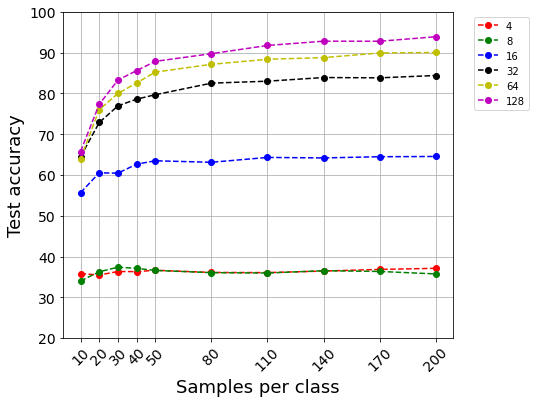

In [27]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,6)

code4_accs = [35.798, 35.473, 36.326, 36.295, 36.636, 36.093, 36.062, 36.434, 36.837, 37.116]
code8_accs = [34.016, 36.264, 37.38, 37.101, 36.589, 36.047, 35.953, 36.527, 36.341, 35.736]
code16_accs = [55.674, 60.527, 60.45, 62.651, 63.488, 63.116, 64.31, 64.186, 64.481, 64.543]
code32_accs = [64.481, 72.884, 76.961, 78.605, 79.69, 82.527, 83.008, 83.907, 83.829, 84.403]
code64_accs = [64.0, 76.031, 80.0, 82.589, 85.24, 87.147, 88.388, 88.791, 89.922, 90.047]
code128_accs = [65.752, 77.364, 83.287, 85.612, 87.876, 89.752, 91.767, 92.822, 92.806, 93.907]

plt.ylim(20, 100)
plt.plot(SAMPLES_PER_CLASS, code4_accs, marker='o', linestyle='--', color='r', label=CODE_SIZES[0])
plt.plot(SAMPLES_PER_CLASS, code8_accs, marker='o', linestyle='--', color='g', label=CODE_SIZES[1])
plt.plot(SAMPLES_PER_CLASS, code16_accs, marker='o', linestyle='--', color='b', label=CODE_SIZES[2])
plt.plot(SAMPLES_PER_CLASS, code32_accs, marker='o', linestyle='--', color='k', label=CODE_SIZES[3])
plt.plot(SAMPLES_PER_CLASS, code64_accs, marker='o', linestyle='--', color='y', label=CODE_SIZES[4])
plt.plot(SAMPLES_PER_CLASS, code128_accs, marker='o', linestyle='--', color='m', label=CODE_SIZES[5])


plt.xlabel("Samples per class", fontsize=18)
plt.ylabel("Test accuracy", fontsize=18) 
plt.grid()
plt.yticks(fontsize=14)
plt.xticks(SAMPLES_PER_CLASS, fontsize=14, rotation=45)
plt.legend(fontsize=14)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()